# Disciple - 取引シミュレーション（Jupyter用）

In [1]:
import datetime
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import load_setting
from funcs.tide import get_date_dir_from_file
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [2]:
# デバッグモード
debug = True

res = AppRes()
excel = "ticks_20260120.xlsx"
# code = "285A"
code = "7011"
# code = "7203"
# code = "8306"
# code = "9984"
dict_setting = load_setting(res, code)
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
TURBULENCE = dict_setting["TURBULENCE"]
THRESHOLD_PM_MIN = dict_setting["THRESHOLD_PM_MIN"]
THRESHOLD_DDR_MIN = dict_setting["THRESHOLD_DDR_MIN"]
date_str = get_date_dir_from_file(excel)
print(date_str)

app = Disciple(excel, code, dict_setting)
app.run()

2026/01/20
パラメータ
PERIOD_WARMUP : 180
PERIOD_MA_1 : 40
PERIOD_MA_2 : 1400
PERIOD_SLOPE : 5
THRESHOLD_SLOPE : 0.05
PERIOD_RR : 30
TURBULENCE : 35.0
LOSSCUT_1 : -25
THRESHOLD_PM_MIN : 10.0
THRESHOLD_DDR_MIN : 0.6
N_MINUS_MAX : 180


In [3]:
# 取引明細
df_transaction = app.getTransaction()
df_transaction["累積損益"] = df_transaction["損益"].fillna(0).cumsum()
print("取引明細")
print(df_transaction)
print(df_transaction["注文日時"].dtype)
print(df_transaction["累積損益"].dtype)

list_html = conv_transaction_df2html(df_transaction)

if debug:
    output_dir = os.path.join("tmp", date_str)
else:
    output_dir = os.path.join("output", date_str)

os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_transaction.html")
print(output)
with open(output, mode="w") as f:
    f.write("\n".join(list_html))

list_trans = df_transaction["注文日時"]
n_trade = len(df_transaction)
total = df_transaction["損益"].sum()
print(f"取引回数: {n_trade} 回 / 総収益: {total} 円/株")

取引明細
    注文番号                          注文日時 銘柄コード  売買  約定単価  約定数量      損益 備考  \
0      1 2026-01-20 09:07:57.896779060  7011  売建  4882   100     NaN      
1      2 2026-01-20 09:08:43.174415112  7011  買埋  4899   100 -1700.0      
2      3 2026-01-20 09:08:44.173645020  7011  買建  4899   100     NaN      
3      4 2026-01-20 09:11:13.799892902  7011  売埋  4905   100   600.0      
4      5 2026-01-20 09:14:01.711896896  7011  売建  4894   100     NaN      
5      6 2026-01-20 09:37:36.211046934  7011  買埋  4849   100  4500.0      
6      7 2026-01-20 09:37:37.225708961  7011  買建  4849   100     NaN      
7      8 2026-01-20 09:42:47.425698996  7011  売埋  4858   100   900.0      
8      9 2026-01-20 09:51:54.318526030  7011  売建  4844   100     NaN      
9     10 2026-01-20 10:05:19.674596071  7011  買埋  4837   100   700.0      
10    11 2026-01-20 10:20:37.969815016  7011  買建  4826   100     NaN      
11    12 2026-01-20 10:21:08.136764050  7011  売埋  4824   100  -200.0      
12    13 2026-01-20 

In [4]:
# Matplotlib の共通設定
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [5]:
"""
累積損益のトレンドを作成するための準備
"""

# 元データ
ts = df_transaction["注文日時"]
pl = df_transaction["累積損益"]

# 日付（年月日）だけ取り出す
date = ts.iloc[0].normalize()

# 追加する先頭と末尾の行
start_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=9)],
        "累積損益": [0.0],
    }
)

end_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=15, minutes=30)],
        "累積損益": [pl.iloc[-1]],
    }
)

# トレンド用 DataFrame を作成
trend_df = pd.concat(
    [start_row, df_transaction[["注文日時", "累積損益"]], end_row], ignore_index=True
)

# 注文日時を index にした Series を作成
trend_series = trend_df.set_index("注文日時")["累積損益"]
trend_series

注文日時
2026-01-20 09:00:00.000000000        0.0
2026-01-20 09:07:57.896779060        0.0
2026-01-20 09:08:43.174415112    -1700.0
2026-01-20 09:08:44.173645020    -1700.0
2026-01-20 09:11:13.799892902    -1100.0
2026-01-20 09:14:01.711896896    -1100.0
2026-01-20 09:37:36.211046934     3400.0
2026-01-20 09:37:37.225708961     3400.0
2026-01-20 09:42:47.425698996     4300.0
2026-01-20 09:51:54.318526030     4300.0
2026-01-20 10:05:19.674596071     5000.0
2026-01-20 10:20:37.969815016     5000.0
2026-01-20 10:21:08.136764050     4800.0
2026-01-20 10:21:55.383955002     4800.0
2026-01-20 10:29:38.627526999     5200.0
2026-01-20 10:36:04.382018089     5200.0
2026-01-20 12:30:38.200926065     7200.0
2026-01-20 13:10:45.301707983     7200.0
2026-01-20 13:12:50.756272078     7200.0
2026-01-20 13:12:51.758846998     7200.0
2026-01-20 13:17:33.315009117     7700.0
2026-01-20 13:26:01.412509918     7700.0
2026-01-20 13:41:29.867150068     8600.0
2026-01-20 13:46:28.257565975     8600.0
2026-01-20 

tmp/2026/01/20/7011_trend_profit.png


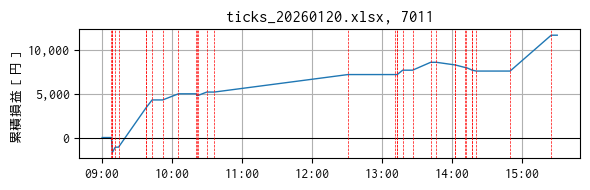

In [6]:
# 累積損益トレンド
fig, ax = plt.subplots(figsize=(6, 2))

ax.set_title(f"{excel}, {code}")
ax.plot(trend_series, linewidth=1)
ax.axhline(y=0, color="black", linewidth=0.75)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("累積損益［円］")
for t in list_trans:
    ax.axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)
ax.grid()

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_profit.png")
print(output)
plt.savefig(output)
plt.show()

In [7]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts  price      ma1          ma2  mr  disparity  \
2026-01-20 09:00:08  1.768867e+09   4861  4861.00  4861.000000   0   0.000000   
2026-01-20 09:00:09  1.768867e+09   4861  4861.00  4861.000000   0   0.000000   
2026-01-20 09:00:10  1.768867e+09   4864  4862.00  4862.000000   3   0.000000   
2026-01-20 09:00:11  1.768867e+09   4864  4862.50  4862.500000   3   0.000000   
2026-01-20 09:00:12  1.768867e+09   4848  4859.60  4859.600000  16   0.000000   
...                           ...    ...      ...          ...  ..        ...   
2026-01-20 15:24:45  1.768890e+09   4807  4803.80  4813.858571  11  -0.002090   
2026-01-20 15:24:46  1.768890e+09   4809  4804.10  4813.838571  12  -0.002023   
2026-01-20 15:24:47  1.768890e+09   4809  4804.40  4813.818571  12  -0.001957   
2026-01-20 15:24:48  1.768890e+09   4807  4804.65  4813.797143  12  -0.001900   
2026-01-20 15:24:49  1.768890e+09   4807  4804.90  4813.775714   9  -0.001844   

                   

In [8]:
df_tech["slope1"].describe()

count    19391.000000
mean         0.076673
std          0.102769
min          0.000000
25%          0.025000
50%          0.050000
75%          0.096667
max          2.574577
Name: slope1, dtype: float64

tmp/2026/01/20/7011_trend_technical.png


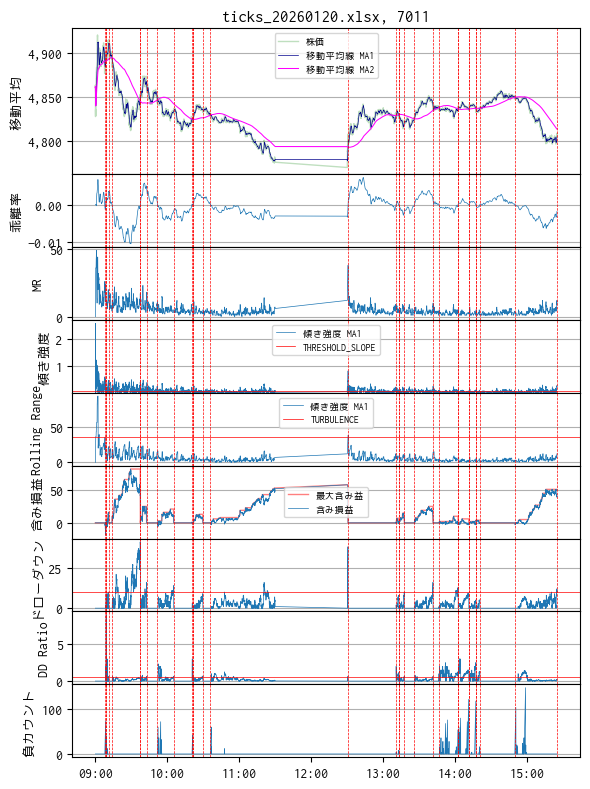

In [9]:
fig = plt.figure(figsize=(6, 8))
n = 9
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")
ax[0].plot(df_tech["price"], linewidth=1, color="green", alpha=0.25, label="株価")
ax[0].plot(df_tech["ma1"], linewidth=0.5, color="darkblue", label="移動平均線 MA1")
ax[0].plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="移動平均線 MA2")
ax[0].set_ylabel("移動平均")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax[0].legend(fontsize=7)

ax[1].plot(df_tech["disparity"], linewidth=0.5, label="MA乖離率")
ax[1].set_ylabel("乖離率")

ax[2].plot(df_tech["mr"], linewidth=0.5, label="移動範囲")
ax[2].set_ylabel("MR")

ax[3].plot(df_tech["slope1"], linewidth=0.5, label="傾き強度 MA1")
ax[3].axhline(y=THRESHOLD_SLOPE, color="red", linewidth=0.5, label="THRESHOLD_SLOPE")
# ax[3].set_yscale("log")
ax[3].set_ylabel("傾き強度")
ax[3].legend(fontsize=7)
_, y_high = ax[3].get_ylim()
ax[3].set_ylim(0.001, y_high)

ax[4].plot(df_tech["rr"], linewidth=0.5, label="傾き強度 MA1")
ax[4].axhline(y=TURBULENCE, color="red", linewidth=0.5, label="TURBULENCE")
ax[4].set_ylabel("Rolling Range")
ax[4].legend(fontsize=7)

ax[5].plot(
    df_tech["profit_max"], linewidth=1, color="red", alpha=0.5, label="最大含み益"
)
ax[5].plot(df_tech["profit"], linewidth=0.5, color="C0", label="含み損益")
ax[5].set_ylabel("含み損益")
ax[5].legend(fontsize=7)

ax[6].plot(df_tech["drawdown"], linewidth=0.5)
ax[6].axhline(y=THRESHOLD_PM_MIN, color="red", linewidth=0.5, label="THRESHOLD_PM_MIN")
ax[6].set_ylabel("ドローダウン")

ax[7].plot(df_tech["dd_ratio"], linewidth=0.5)
ax[7].axhline(
    y=THRESHOLD_DDR_MIN, color="red", linewidth=0.5, label="THRESHOLD_DDR_MIN"
)
ax[7].set_ylabel("DD Ratio")

ax[8].plot(df_tech["n_minus"], linewidth=0.5)
ax[8].set_ylabel("負カウント")

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_technical.png")
print(output)
plt.savefig(output)
plt.show()

tmp/2026/01/20/7011_hist_slope.png


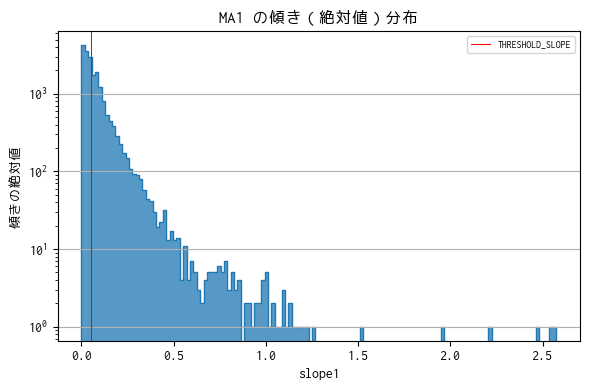

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("MA1 の傾き（絶対値）分布")
sns.histplot(data=df_tech, x="slope1", bins="sqrt", element="step")
ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
ax.set_yscale("log")
ax.set_ylabel("傾きの絶対値")
ax.grid(axis="y")
ax.legend(fontsize=7)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_hist_slope.png")
print(output)
plt.savefig(output)
plt.show()

tmp/2026/01/20/7011_hist_rr.png


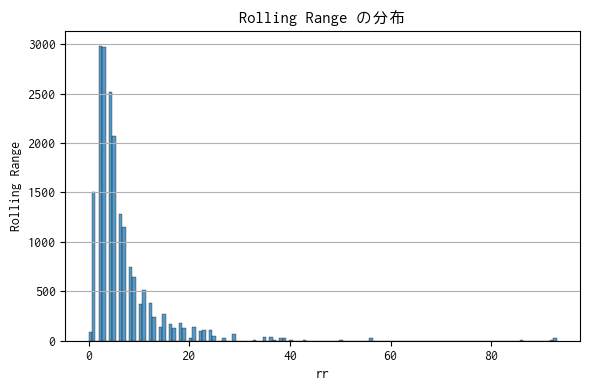

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Rolling Range の分布")
sns.histplot(data=df_tech, x="rr", bins="sqrt")
# ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
# ax.set_yscale("log")
ax.set_ylabel("Rolling Range")
ax.grid(axis="y")
# ax.legend(fontsize=7)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_hist_rr.png")
print(output)
plt.savefig(output)
plt.show()

In [12]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  乱高下  ロス1  ロス2  利確1   建玉
2026-01-20 09:00:08    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-20 09:00:09    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-20 09:00:10    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-20 09:00:11    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-20 09:00:12    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
...                    ...    ...  ...  ...  ...  ...  ...  ...
2026-01-20 15:24:45    0.0    0.0  0.0  0.0  0.0  0.0  0.0 -1.0
2026-01-20 15:24:46    0.0    0.0  0.0  0.0  0.0  0.0  0.0 -1.0
2026-01-20 15:24:47    0.0    0.0  0.0  0.0  0.0  0.0  0.0 -1.0
2026-01-20 15:24:48    0.0    0.0  0.0  0.0  0.0  0.0  0.0 -1.0
2026-01-20 15:24:49    0.0    0.0  0.0  0.0  0.0  0.0  0.0 -1.0

[19391 rows x 8 columns]


tmp/2026/01/20/7011_trend_obs.png


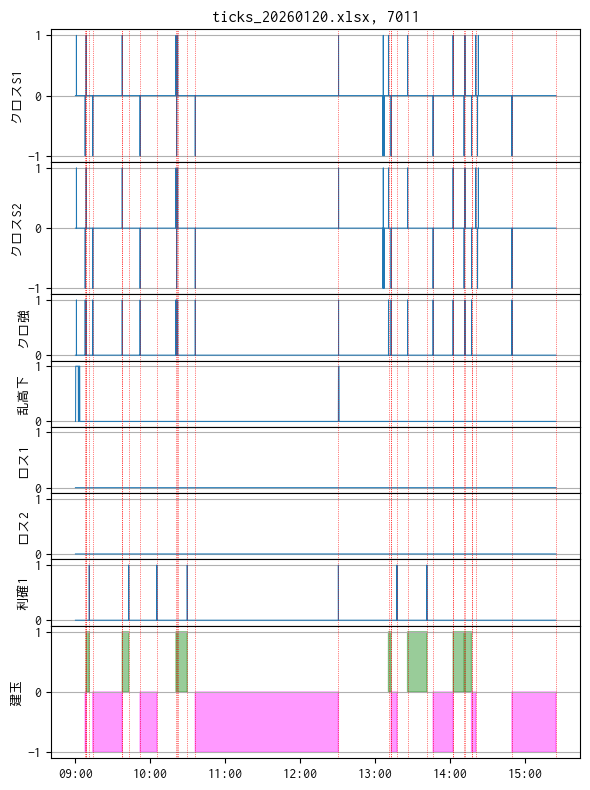

In [13]:
n = len(df_obs.columns)
fig = plt.figure(figsize=(6, n))
ax = dict()

targets = {"クロスS1", "クロスS2", "建玉"}
list_height_ratio = [2 if col in targets else 1 for col in df_obs.columns]
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=list_height_ratio)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")

special_cross = {"クロスS1", "クロスS2"}

for i, colname in enumerate(df_obs.columns):
    ax_i = ax[i]

    if colname in special_cross:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-1.1, 1.1)

    elif colname == "建玉":
        x = df_obs.index
        y = df_obs[colname]
        ax_i.fill_between(
            x, 0, y, where=y > 0, color="green", alpha=0.4, interpolate=True
        )
        ax_i.fill_between(
            x, 0, y, where=y < 0, color="magenta", alpha=0.4, interpolate=True
        )
        ax_i.set_ylim(-1.1, 1.1)

    else:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-0.1, 1.1)

    ax_i.set_ylabel(colname)
    ax_i.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_obs.png")
print(output)
plt.tight_layout()
plt.savefig(output)
plt.show()